# 2. End-to-End Machine Learning Project


### Settings

<H2 style = "text-align:center"> os module</H2>

`os.mkdir` 與 `os.makedirs` 都是用來建立新目錄的函數，但是有幾個差異：
1. `os.mkdir` 只能建立一層目錄，若目錄的上層目錄不存在，則會拋出 FileNotFoundError 的異常，因此必須先建立上層目錄才能使用此函數。
而 `os.makedirs` 則可以建立多層目錄，若上層目錄不存在，則會自動建立。

2. `os.mkdir` 的函數原型為 `os.mkdir(path, mode=0o777, *, dir_fd=None)`，其中 `mode` 參數可以指定新建目錄的權限。而 `os.makedirs` 的函數原型為 `os.makedirs(name, mode=0o777, exist_ok=False)`, 其中 `exist_ok` 參數為 False 時，如果目錄已經存在，則會拋出 FileExistsError 的異常。

因此，如果需要建立多層目錄或是確定上層目錄已存在，建議使用 `os.makedirs`。反之，若只需建立一層目錄且確定上層目錄已存在，則可以使用 `os.mkdir`。

<H2 style = "text-align:center"> pathlib module</H2>

在 `Path.mkdir()` 方法中，`parents` 參數可以用來建立不存在的父目錄。

如果將 `parents` 設置為 True，那麼 `mkdir()` 將會建立不存在的父目錄。例如，如果你呼叫 Path("foo/bar/baz").mkdir(parents=True)，且 foo 和 bar 目錄都不存在，mkdir() 會建立這兩個目錄以及 baz 目錄。

如果 `parents` 設置為 False（預設值），那麼 `mkdir()` 將只建立路徑中最後一個目錄，如果任何父目錄不存在則會拋出 <span style="color:red">FileNotFoundError</span>。

In [1]:
from pathlib import Path
import tarfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IMAGES_PATH = Path("images") / 'Chapter 2 end to end project'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# plt setting

params = {
   'font.size': 14,
   'axes.labelsize': 14,
   'axes.titlesize': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
}

plt.rcParams.update(params)

### Get the DataGet the Data
### Download the Data

In [2]:
def save_fig(figname, tight_layout=True, figext="png", resolution=300, update=False):
    full_figname = f"{figname}.{figext}"
    figpath = IMAGES_PATH / full_figname
    if tight_layout:
        plt.tight_layout()
    if update or not figpath.is_file():
        plt.savefig(figpath, format=figext, dpi=resolution)
    else:
        print(f"File '{full_figname}' already exists, use 'update=True' to overwrite")

In [3]:
def load_housing_data(destination_dir='datasets', filename='housing.tgz', 
                      source_url='https://github.com/ageron/data/raw/main/housing.tgz'):
    tgz_path = Path(destination_dir) / filename
    if not tgz_path.is_file():
        Path(destination_dir).mkdir(parents=True, exist_ok=True)
        urllib.request.urlretrieve(source_url, tgz_path)
        with tarfile.open(tgz_path) as housing_tgz:
            housing_tgz.extractall(path=destination_dir)
    return pd.read_csv(Path(destination_dir) / Path(filename).stem / Path(filename).with_suffix('.csv'))
housing = load_housing_data()

#### Take a Quick Look at the Data Structure

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


發現`total_bedrooms`有null值，後續分析要處理缺值問題。

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


File 'attribute_histogram_plots.png' already exists, use 'update=True' to overwrite


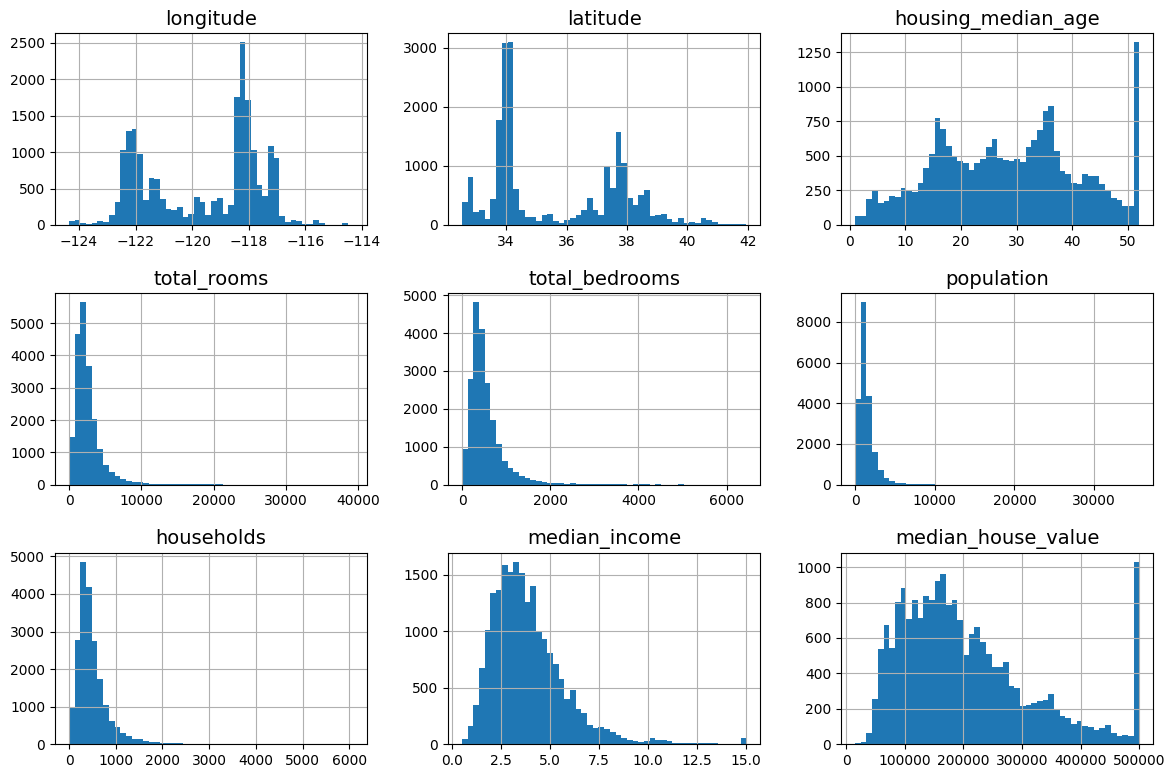

In [8]:
housing.hist(bins=50, figsize=(12,8))
save_fig("attribute_histogram_plots")
plt.show()

#### Create a Test Set

In [9]:
def shuffle_and_split_data(data, test_ratio, random_state=42):
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)
print('train set:', train_set.shape, 'test set', test_set.shape)

train set: (16512, 10) test set (4128, 10)


This video provides a brief introduction to how crc32 works: https://www.youtube.com/watch?v=1NlzKh9e4Gs. 

You can also check out the Wikipedia page on crc32 at https://en.wikipedia.org/wiki/Cyclic_redundancy_check.


In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, test_ratio=0.2, id_column="index")

In [13]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [16]:
# import train test split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_with_id, test_size=0.2, random_state=42)

In [17]:
test_set['total_bedrooms'].isnull().sum()

44

將`income`切分成category型。

In [18]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3., 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5])

當你畫圖時，如果使用 `hist` 函數，x 軸會是連續型的。

如果你希望 x 軸呈現為類別型資料，可以先使用 `value_counts` 函數來計算各個類別的出現次數，然後再使用 `bar` 函數繪製條形圖。

File 'housing_income_cat_hist_plot.png' already exists, use 'update=True' to overwrite


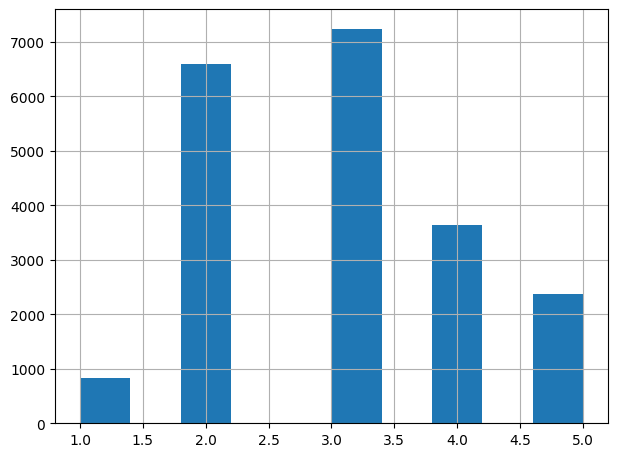

In [19]:
housing['income_cat'].hist()
save_fig("housing_income_cat_hist_plot")
plt.show()

File 'housing_income_cat_bar_plot.png' already exists, use 'update=True' to overwrite


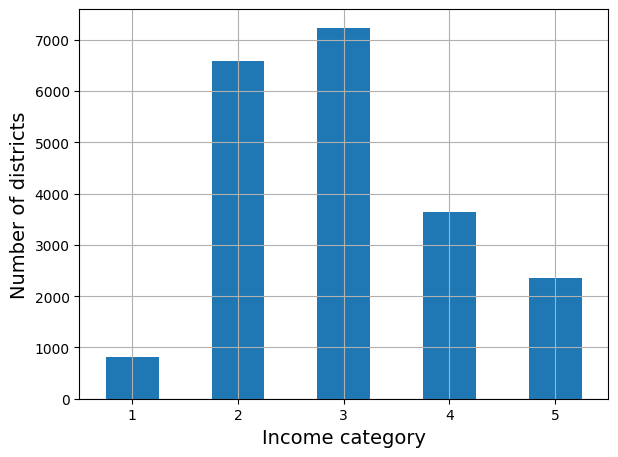

In [20]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

`n_splits=1`: 分割成幾組，這裡指定為 1 組\
`test_size=0.2`: 分割出的測試集比例為 20%\
`random_state=42`: 設定隨機種子，確保每次執行時結果相同

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

`StratifiedShuffleSplit.split()` 回傳的是一個 generator，所以可以用 `for` 迴圈依序取出多組訓練集和測試集。\
當然也可以用`train_index, test_index = next(split.split(housing, housing['income_cat']))`

In [22]:
strat_splits = [] # sometimes you may construct multiple train/test sets (e.g. cross-validation)
for train_index, test_index in splitter.split(housing, housing['income_cat']):
    strat_train_set_ = housing.loc[train_index]
    strat_test_set_ = housing.loc[test_index]
    strat_splits.append([strat_train_set_, strat_test_set_])
strat_train_set, strat_test_set = strat_splits[0]

In [23]:
strat_test_set['income_cat'].value_counts(normalize=True)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: proportion, dtype: float64

In [24]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
compare_props = pd.DataFrame({
    "Overall %": housing['income_cat'].value_counts(normalize=True),
    "Stratified %": strat_test_set['income_cat'].value_counts(normalize=True),
    "Random %": test_set['income_cat'].value_counts(normalize=True),
}).sort_index()
compare_props.index.name = 'Income Category'
compare_props['Strat Error %'] = compare_props['Stratified %']/compare_props['Overall %'] - 1
compare_props['Random Error %'] = compare_props['Random %']/compare_props['Overall %'] - 1
(compare_props*100).round(2)

,Overall %,Stratified %,Random %,Strat Error %,Random Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


使用 `set_` 的目的是區別變數名稱與 set 這個 Python 內建函數。此外，在 for 迴圈中我們只是需要暫時用到 `strat_train_set` 和 `strat_test_set` 這兩個變數，因此使用底線後綴表示這些變數是暫時的，不需要保存到後面的操作中。

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

### Explore and Visualize the Data to Gain Insights
#### Visualizing Geographical Data

`pd.DataFrame.copy()` 方法的預設行為是進行深拷貝，也就是 `deep=True`。

In [26]:
housing = strat_train_set.copy()

畫scatter plot時，如果資料點過於密集，很難看出密集程度的差別。\
因此可以使用 `alpha` 參數來調整點的透明度，使得點的差異更加明顯，這對於觀察密集程度差異較大的資料特別有幫助。

File 'bad_visualization_plot.png' already exists, use 'update=True' to overwrite


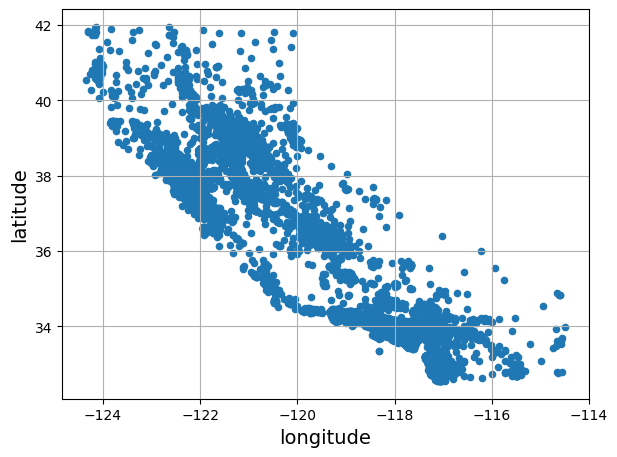

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
save_fig('bad_visualization_plot')
plt.show()

File 'better_visualization_plot.png' already exists, use 'update=True' to overwrite


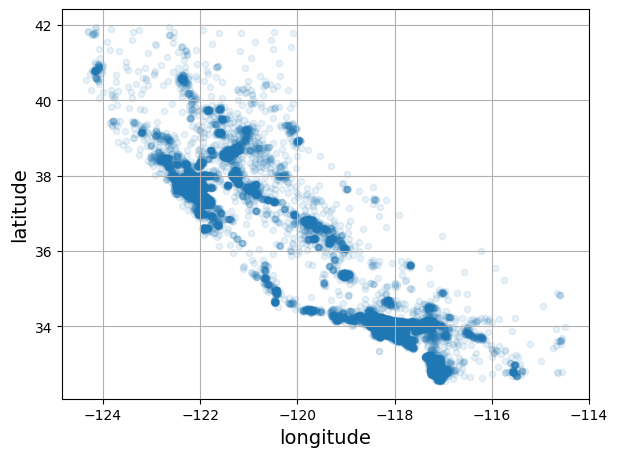

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.1)
save_fig('better_visualization_plot')
plt.show()

`s` 參數代表著每個點的半徑大小，`c` 參數代表著每個點的顏色。\
`s` 參數被設定為 `housing['population']/100`，使用每個點所代表城市的人口數來調整點的大小。\
`c` 參數被設定為 `median_house_value`，使用每個點所代表城市的房屋價格中位數來調整點的顏色。

File 'housing_price_scatterplot.png' already exists, use 'update=True' to overwrite


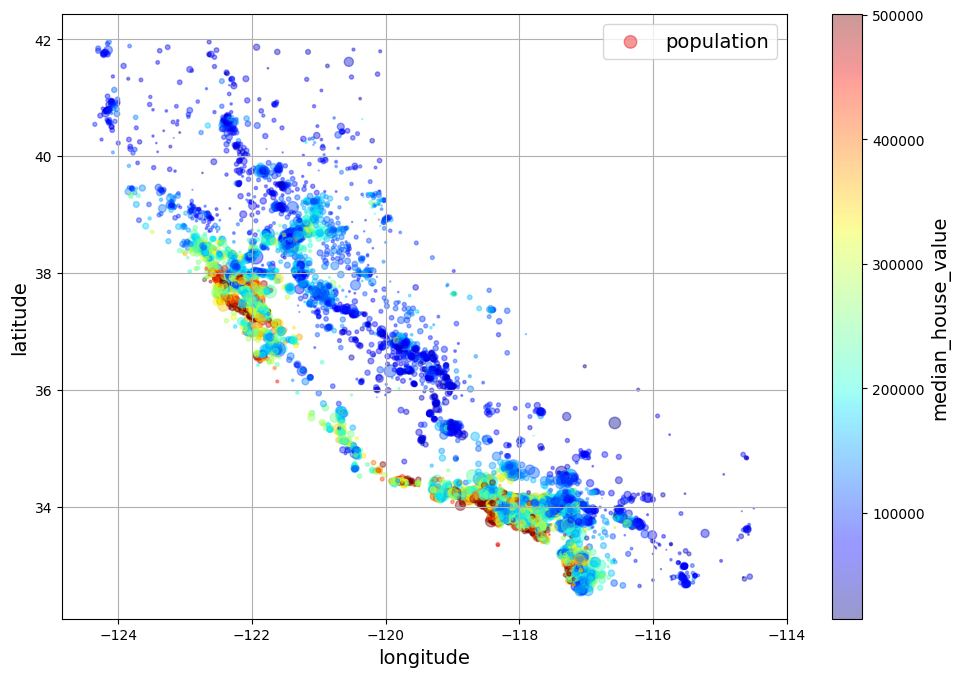

In [29]:
housing.plot(kind='scatter', x='longitude', y='latitude', s=housing['population']/100, 
             alpha = 0.4, c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             legend=True, grid=True, label='population', figsize=(10,7))
save_fig('housing_price_scatterplot')
plt.show()

`imshow()`函數可以將圖像以圖像的方式顯示在軸上

File 'california_housing_prices_plot.png' already exists, use 'update=True' to overwrite


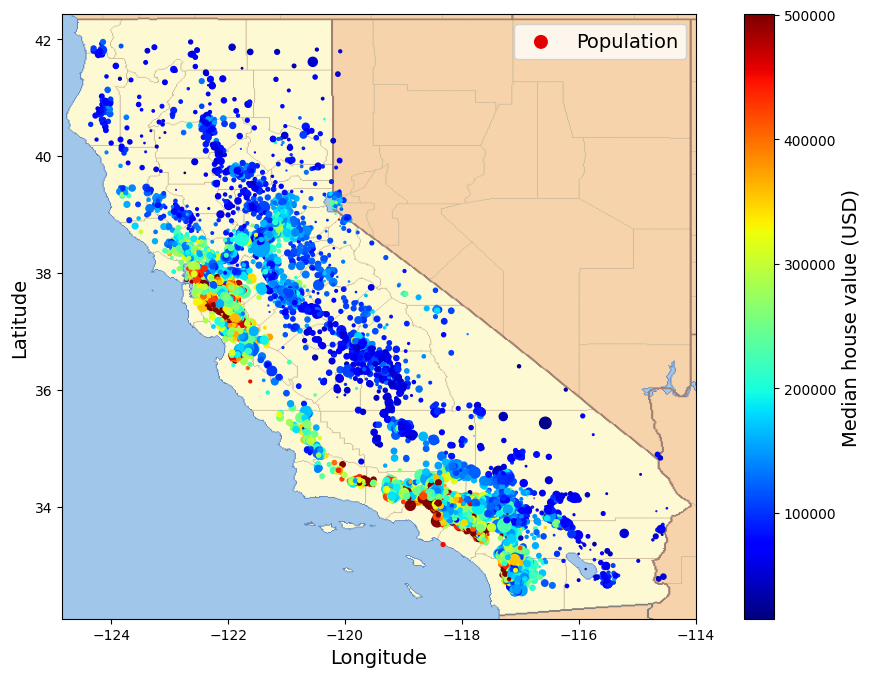

In [30]:
import matplotlib.pyplot as plt
filename = 'california.png'
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = Path(homl3_root, "images/end_to_end_project/", filename)
    print('Downloading', filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude",
                     s=housing_renamed['Population'] / 100, label="Population",
                     c="Median house value (USD)", cmap="jet", colorbar=True,
                     legend=True, figsize=(10,7))

california_img = plt.imread(IMAGES_PATH / filename)
plt.imshow(california_img, extent=[*plt.gca().get_xlim(), *plt.gca().get_ylim()])
save_fig('california_housing_prices_plot')
plt.show()

#### Look for Correlations

在 pandas 2.0.0 版本中，`numeric_only` 的默認值從 `True` 更改為 `False` 。如果希望只包括浮點數、整數或布林值，可以在使用 `corr()` 時指定 `numeric_only=True` 。

In [31]:
corr_matrix = housing.corr(numeric_only=True)

In [32]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

File 'scatter_matrix_plot.png' already exists, use 'update=True' to overwrite


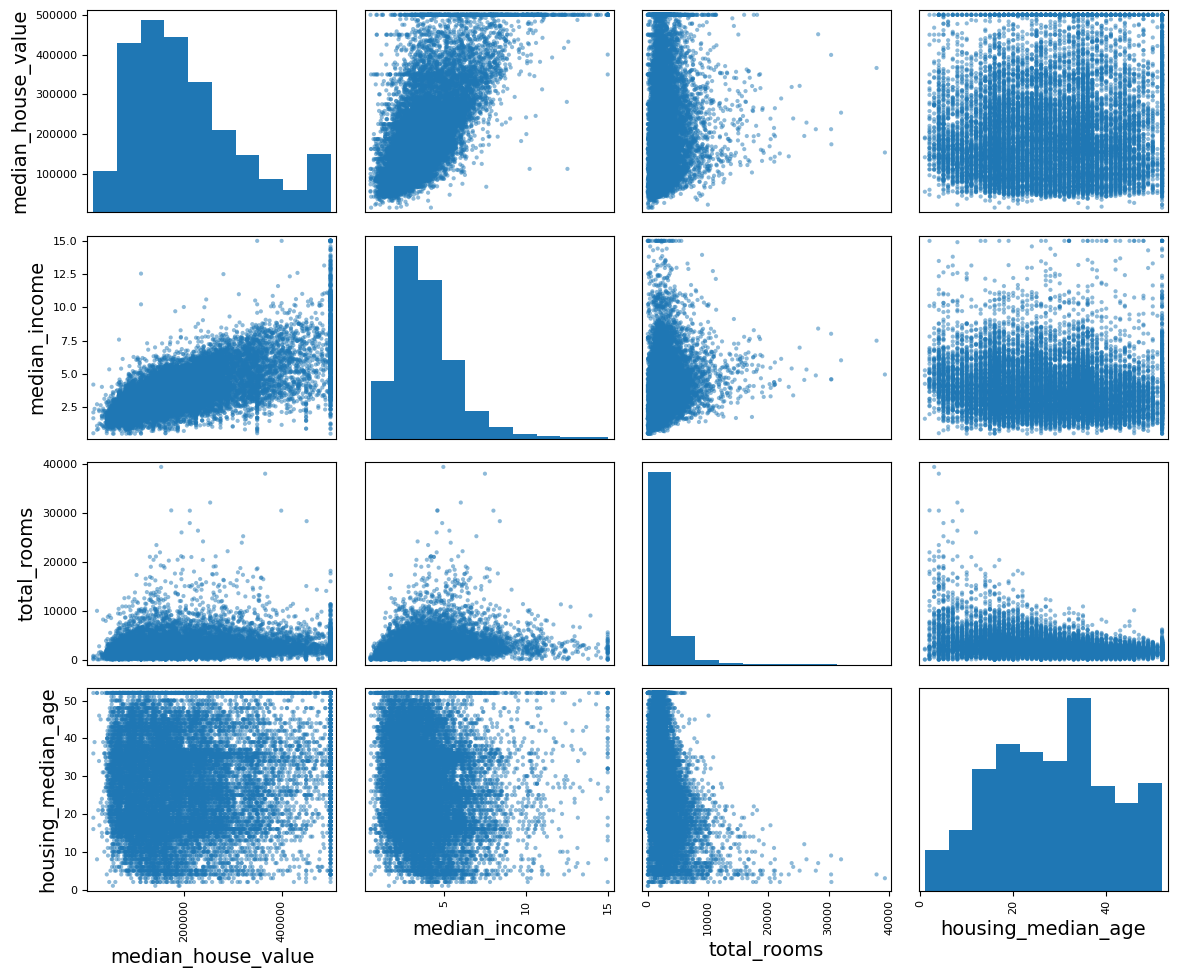

In [33]:
from pandas.plotting import scatter_matrix
attributes = attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,10))
save_fig('scatter_matrix_plot')
plt.show()

我們發現有強相關性，另外`median_house_value`在500000被截斷。

File 'income_vs_house_value_scatterplot.png' already exists, use 'update=True' to overwrite


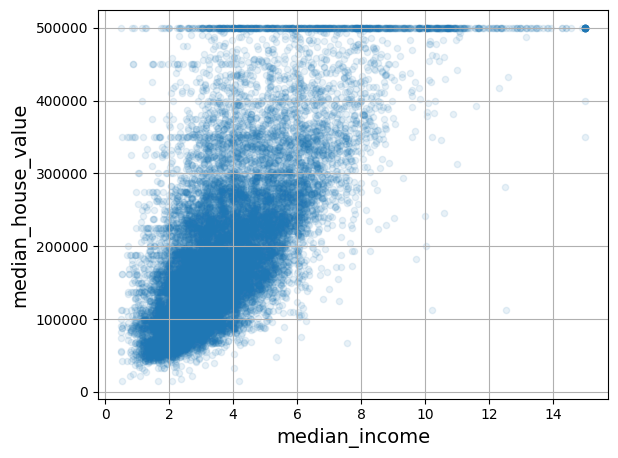

In [34]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
save_fig('income_vs_house_value_scatterplot')
plt.show()

#### Experiment with Attribute Combinations

In [35]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [36]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.143663
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
people_per_house      -0.038224
longitude             -0.050859
latitude              -0.139584
bedrooms_ratio        -0.256397
Name: median_house_value, dtype: float64

### Prepare the Data for Machine Learning Algorithms

`pd.drop()` 本身就具有複製的效果了，所以不會影響到原本的 `strat_train_set`。但 `strat_train_set['median_house_value']`就需要用 `copy()`。

In [37]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

#### Clean the Data

+ 刪除 "ocean_proximity" 欄位中含有缺失值的資料列
    ```python
    housing.dropna(subset=["total_bedrooms"], inplace=True)
    ```
+ 刪除名為 "ocean_proximity" 的欄位，若欄位含有缺失值也會被刪除
    ```python
    housing.dropna('total_bedrooms', axis=1)
    ```
+ 將 "total_bedrooms" 欄位中的缺失值以該欄位的中位數進行填補
    ```python
    housing['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)
    ```

In [38]:
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx,:].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [39]:
# option 1 
housing_option1 = housing.copy()
housing_option1.dropna(subset=["total_bedrooms"], inplace=True)
housing_option1.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
# option 2
housing_option2 = housing.copy()
housing_option2.drop('total_bedrooms', axis=1, inplace=True)
housing_option2.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [41]:
# option 3
housing_option3 = housing.copy()
median = housing_option3['total_bedrooms'].median()
housing_option3['total_bedrooms'].fillna(median, inplace=True)
housing_option3.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


`strategy` in `SimpleImputer`
+ `mean`
+ `median`
+ `most_frequent`
+ `constant`

In [42]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [43]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
# 各個變數的median
print('imputer result', imputer.statistics_, sep=':\n')
print('pandas result', housing_num.median(axis=0).values, sep=':\n')

imputer result:
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
pandas result:
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


`imputer.feature_names_in_`可以看有哪些變數被放進去這個inputer中。

In [45]:
import pandas as pd
X = imputer.transform(housing_num)
print(f"Imputer features: {imputer.feature_names_in_}")
print(f"Imputer strategy: {imputer.strategy}")

Imputer features: ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income']
Imputer strategy: median


In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.loc[null_rows_idx].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


清除outlier

In [47]:
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [48]:
# housing = housing.iloc[outlier_pred == 1]
# housing_labels = housing_labels.iloc[outlier_pred == 1]

In [49]:
housing_cat = housing.select_dtypes(include=['object'])
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [50]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

當初被分類的categories都被保留在encoder裡面(sklearn裡的API幾乎都有這樣的特性)

In [51]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [52]:
onehot_encoder = OneHotEncoder()
housing_cat_onehot = onehot_encoder.fit_transform(housing_cat)

你會發現 `housing_cat_onehot` 只會告訴你是稀疏矩陣，因為本來裡面就很多0，這樣可以節省記憶體空間，並且可以像一般的2D array一樣使用。

In [53]:
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

如果真的想要把他轉回2D array的話，可以用toarray，或是一開始就用關鍵字`sparse=False`
```python
OneHotEncoder(sparse=False)
```

In [54]:
housing_cat_onehot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

在encoder中有當初encode變數的相關資訊，如果之後要轉成pandas dataframe的話可以使用，

In [55]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [56]:
onehot_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [57]:
onehot_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [58]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [59]:
onehot_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [60]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


In [61]:
onehot_encoder.handle_unknown = "ignore"
onehot_encoder.transform(df_test_unknown).toarray()

array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [62]:
df_output = pd.DataFrame(onehot_encoder.transform(df_test_unknown).toarray(),
                         columns=onehot_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


#### Feature Scaling and Transformation
在特徵縮放和轉換中，常見的兩種方法是 **<span style="color:steelblue">最小-最大縮放（Min-max scaling, Normalization）</span>** 和 **<span style="color:steelblue">標準化（Standardization）</span>**。

In [63]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

當處理非常態分佈的特徵時，可以使用以下方法進行轉換：

+ 右偏的正數特徵，可以使用平方根或介於0和1之間的幂次方來替換特徵值，以使分佈縮小並接近對稱。
+ 如果右偏得非常嚴重，例如指數分佈，可以使用`log`轉換來調整。
+ 將特徵進行分桶處理，將分佈切割成大致相等大小的桶（bucket），並將特徵值替換為所屬桶的index，以獲得均勻分布的特徵。
+ 多峰分布的特徵
    - 可以考慮將特徵進行分桶，並將桶的索引視為類別值，而不是數值，以幫助模型學習不同範圍的規則。
    - 添加相似度相關的特徵。可以使用基於距離的核函數（如高斯核函數）計算特徵與固定點之間的相似度。

File 'long_tail_plot.png' already exists, use 'update=True' to overwrite


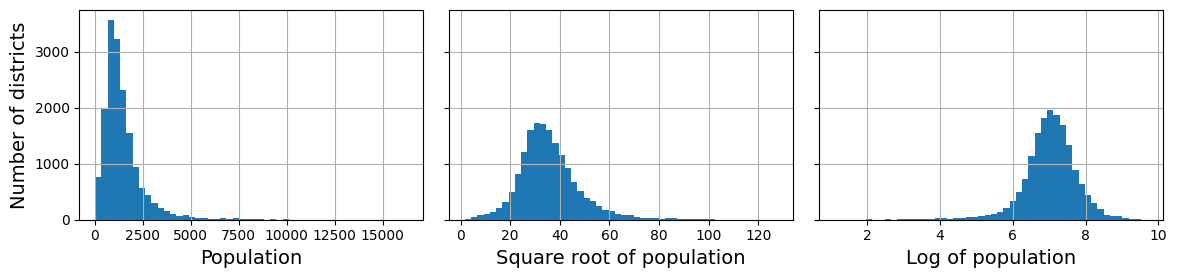

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.sqrt).hist(ax=axs[1], bins=50)
housing["population"].apply(np.log).hist(ax=axs[2], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Square root of population")
axs[2].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()

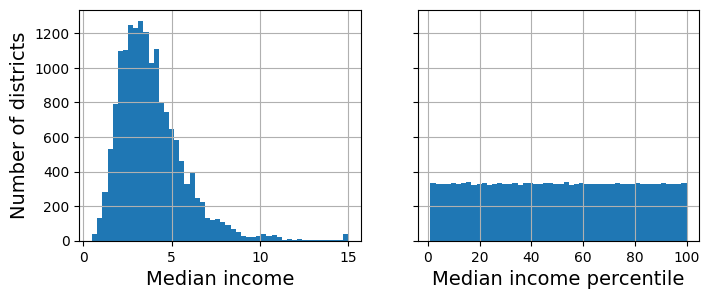

In [65]:
percentiles = np.percentile(housing["median_income"],range(1, 100)).tolist()
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["median_income"].hist(ax=axs[0], bins=50)
flattened_median_income.hist(ax=axs[1], bins=50)
# save_fig("long_tail_plot")
axs[0].set_xlabel("Median income")
axs[1].set_xlabel("Median income percentile")
axs[0].set_ylabel("Number of districts")
plt.show()

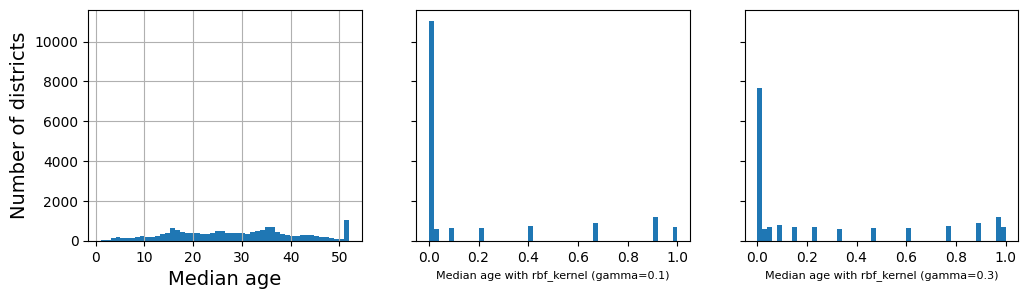

In [66]:
from sklearn.metrics.pairwise import rbf_kernel
gamma1 = 0.1
gamma2 = 0.03
rbf1_median_age = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=gamma1)
rbf2_median_age = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=gamma2)

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
housing["housing_median_age"].hist(ax=axs[0], bins=50)
axs[1].hist(rbf1_median_age, bins=50)
axs[2].hist(rbf2_median_age, bins=50)
axs[0].set_xlabel("Median age")
axs[1].set_xlabel("Median age with rbf_kernel (gamma=0.1)", size=8)
axs[2].set_xlabel("Median age with rbf_kernel (gamma=0.3)", size=8)
axs[0].set_ylabel("Number of districts")
plt.show()

有時候我們需要對**目標變量進行轉換**，這時可以使用轉換器（transformer）中的 `inverse_transform` 方法將其**轉換回原始的目標變量**。

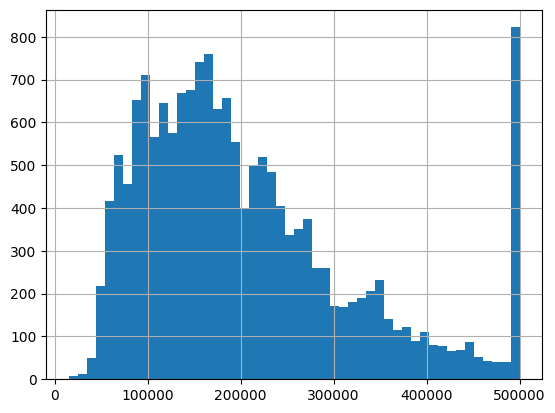

In [67]:
housing_labels.hist(bins=50)
plt.show()

In [68]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

linearmodel = LinearRegression()
linearmodel.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5]  # pretend this is new data

scaled_predictions = linearmodel.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

In [69]:
predictions.shape

(5, 1)

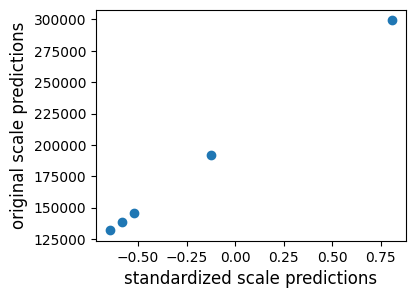

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.scatter(scaled_predictions, predictions)
ax.set_xlabel('standardized scale predictions', size=12)
ax.set_ylabel('original scale predictions', size=12)
plt.show()

In [71]:
from sklearn.compose import TransformedTargetRegressor

tr_linearmodel = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
tr_linearmodel.fit(housing[["median_income"]], housing_labels)
predictions = tr_linearmodel.predict(some_new_data)
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

In [72]:
predictions.shape

(5,)

從 `LinearRegression().predict` 和 `TransformedTargetRegressor().predict` 獲得的predictions之間的形狀差異是由於在每種情況下處理目標變量的方式。

+ 在 `LinearRegression` 的情況下，`scaled_labels` 已經使用 `StandardScaler` 進行了轉換，從而產生形狀為 (5, 1) 的二維數組。 **當你對 `LinearRegression` 調用預測時，它會返回具有相同形狀的預測**。
+ `TransformedTargetRegressor` 使用 `StandardScaler` 在內部處理目標變量的轉換。 但是，它將目標變量以其`housing_labels` 存儲以供將來使用，例如逆變換或評估。 **當你在 TransformedTargetRegressor 調用預測時，它會以原始形式返回預測**，也就是一個形狀為 (5,) 的一維數組。

結論而言，兩種方法都會回傳跟原始數組一樣形狀的結果，但`StandardScaler`會從 (5,) 的一維數組產生形狀為 (5, 1)的二維數組，需要特別小心。

#### Custom Transformers

如果自定義的transformer不需要被訓練，可以使用`FunctionTransformer`，其中的`inverse_func`是選配的，加了之後可以呼叫`inverse_transform`

In [73]:
from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

In [74]:
log_pop

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905
...,...
14207,6.843750
13105,7.257708
19301,7.942362
19121,7.452982


剛才的`rbf_kernel`也可以變成Transformer，但他本身不具有`inverse_func`。

`kw_args`是`FunctionTransformer`的一個參數，用於指定傳遞給 **<span style="color:steelblue">轉換函數</span>** 的關鍵字參數（keyword arguments）。在這個例子中，關鍵字參數`kw_args`將被傳遞給`rbf_kernel`函數。

In [75]:
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
rbf_median_age = rbf_transformer.transform(housing[["housing_median_age"]])

In [76]:
rbf_median_age

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

`rbf_kernel`是一個用於計算樣本之間高斯相似性的函數，它可以處理多維度的輸入。

假設 $X$ 是一個 $m \times p$ 的二維陣列，$Y$ 是一個 $n \times p$ 的二維陣列，則 `rbf_kernel` 的結果是一個 $m \times n$ 的陣列，其中每個元素 $K(X, Y)_{ij}$ 的計算方式為：
$$K(X, Y)_{ij} = exp(-\gamma ||X_{i,:}-Y_{j,:}||^2)$$
例如，我們可以比較觀測點的經緯度與 **<span style="color:steelblue">舊金山(緯度=37.7749, 經度=-122.41)</span>** 之間的相似度

In [77]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [78]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

此外，我們也可以使用`transformer`來進行變數間的運算，例如對兩個欄位進行相除操作。

In [79]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

除了使用不需被訓練的`transformer`外，我們有時希望從數據中獲取一些訊息來自定義我們的`transformer`。在`scikit-learn`中，我們可以使用一些基礎結構來構建我們的`transformer`，其中包括 **<span style="color:steelblue">BaseEstimator</span>** 和 **<span style="color:steelblue">TransformerMixin</span>**。

+ **<span style="color:steelblue">BaseEstimator</span>** 提供了一些基本方法，例如`get_params`和`set_params`。這些方法可以讓我們在`transformer`中輕鬆存取和設置參數，以便根據需要進行調整。

+ **<span style="color:steelblue">TransformerMixin</span>** 則提供了一些方法，例如`fit_transform`和`set_output`。`fit_transform`方法用於執行擬合和轉換操作，並根據需要返回轉換後的數據。`set_output`方法則用於設置轉換的輸出。

舉個例子來說，如果我們應用了 **<span style="color:steelblue">TransformerMixin</span>** ，它的`fit_transform`方法會自動調用我們定義的`transformer`的`fit`和`transform`方法，這是因為Python是一種遵循 **<span style="color:steelblue">鴨子類型 (duck typing)</span>** 的語言。

> **<span style="color:steelblue">Duck typing</span>** 是一種動態語言中的設計理念，其中**物件的有效性不是由其類型（type）本身決定**的，而是**由其方法和屬性（attributes）是否存在決定**的。這意味著當一個物件被傳遞給一個方法時，**方法將檢查物件是否有所需的方法和屬性，而不是檢查物件的類型**。這種方法使得代碼更加靈活，因為它可以處理不同的物件，只要它們具有所需的方法和屬性即可。通常，Duck typing是動態語言的特點(如Python)，而靜態語言(如Java)通常不使用這種技術。
> 

In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):  # no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

- `check_array`函數用於驗證數據陣列的格式和內容。它可以確保輸入的數據陣列符合預期的形狀、數據類型和其他屬性。如果數據陣列不符合要求，該函數將引發相應的驗證錯誤，從而幫助檢測和修正數據問題。
- `check_is_fitted`函數用於驗證模型是否已經 fit 過數據。在使用許多`scikit-learn`的模型時，我們需要確保模型已經適應了數據，才能進行後續的預測或轉換操作。`check_is_fitted`函數可以檢查模型是否已經適應了數據，如果模型未擬合，則會引發錯誤。

<details> 
  <summary style="color:darkorange"; display="block"><b><u> check_is_fitted 是怎麼運作的?</u></b></summary>

  `check_is_fitted` 函數是通過**檢查指定的模型屬性**來判斷模型是否已經fit了數據。這個函數需要兩個參數：**estimator**和**attributes**。

  + `estimator`是指要檢查的模型實例。
  + `attributes`是一個字符串或字符串列表，表示要檢查的模型屬性。
  
  函數的運作方式如下：

  1. 首先，函數會檢查`estimator`是否具有`_estimator_type`屬性，如果沒有，則會引發 **<span style="color:red">AttributeError</span>** 錯誤。
  2. 接下來，函數會檢查`attributes`參數，如果是字符串(string)，則將其轉換為單個元素的列表(list)。
  3. 對於`attributes`列表中的每個屬性名稱，函數會使用`hasattr`函數檢查`estimator`是否具有該屬性。
  4. 如果所有屬性都存在，則函數執行成功；否則，將引發 **<span style="color:red">NotFittedError</span>** 錯誤，指示模型未fit數據。

</details>

當然，我們不僅僅限於使用基礎的估計器 (`BaseEstimator`)，我們還可以使用一些更高級的估計器，例如 `K-means`。

In [81]:
from sklearn.cluster import KMeans

class ClusterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state, n_init='auto')
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [82]:
cluster_transformer = ClusterTransformer(n_clusters=10, gamma=1., random_state=42)
cluster_simil = cluster_transformer.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

In [83]:
housing[["latitude", "longitude"]].shape

(16512, 2)

In [84]:
cluster_transformer.kmeans_.cluster_centers_.shape

(10, 2)

In [85]:
cluster_simil.shape

(16512, 10)

File 'district_cluster_plot.png' already exists, use 'update=True' to overwrite


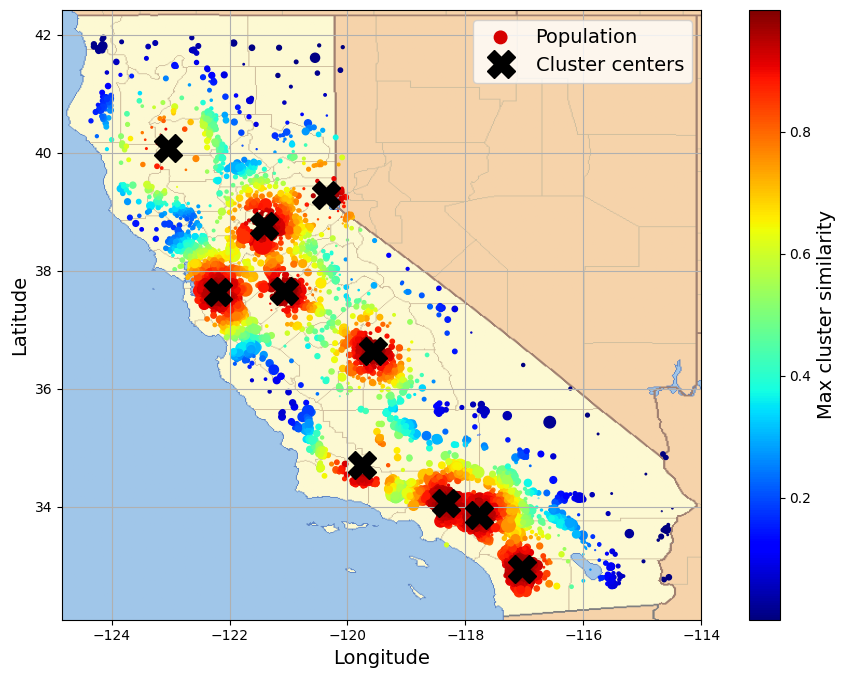

In [86]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})
housing_renamed["Max cluster similarity"] = cluster_simil.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
plt.plot(cluster_transformer.kmeans_.cluster_centers_[:, 1],
         cluster_transformer.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.imshow(california_img, extent=[*plt.gca().get_xlim(), *plt.gca().get_ylim()])
plt.legend(loc="upper right")
save_fig("district_cluster_plot")
plt.show()

#### Transformation Pipelines

`Scikit-Learn`的Pipeline API提供了一種便捷的方式來構建轉換流程。Pipeline由一系列的`(name, estimator)`組成的列表構成，其中每個元素都是一個步驟，並指定了該步驟的名稱（可以自由設定，但不能包含雙底線__）和對應的`estimator`。

除了Pipeline的最後一個`estimator`外，每個`estimator`都需要實現`fit_transform`方法，即需要是一個`transformer`。這些`transformer`用於對數據進行轉換，例如特徵縮放、特徵選擇等。最後一個`estimator`可以是一個`transformer`或一個模型（`estimator`）用於進行最終的預測。

Pipeline提供了一種方便的方法來將多個轉換步驟串聯起來，並且可以一次性應用到數據上。**可以保證每個轉換步驟都在正確的順序中應用，並且可以輕鬆地將這個流程應用到新的數據上**。

In [87]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [88]:
print(num_pipeline.named_steps) # dictionary-like
print(num_pipeline.steps)       # list of tuple like

{'impute': SimpleImputer(strategy='median'), 'standardize': StandardScaler()}
[('impute', SimpleImputer(strategy='median')), ('standardize', StandardScaler())]


Scikit-Learn還提供了一個方便的函數`make_pipeline`，可以**自動**為每個轉換器生成名稱，這些名稱是根據轉換器的類型來自動命名的，並且是**全小寫且不包含底線_的**。如果有多個轉換器用相同的名字，它會自動加上編號(`bla-1`, `bla-2`)，

In [89]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [90]:
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [91]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

在使用`Transformer`進行轉換時，一個稍微麻煩的地方是它的輸出是`NumPy陣列(np array)`，而不是直接返回一個`DataFrame`。因此，我們需要自己手動建立一個`DataFrame`。

此外，需要注意的是，有時候Pipeline的輸入和輸出的欄位數量可能不相同。這時可以使用`get_feature_names_out`方法來獲取Pipeline輸出的特徵名稱。這個方法可以讓我們方便地獲取轉換後的特徵名稱。

In [92]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

df_housing_num_prepared.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942


In [93]:
num_pipeline.steps

[('simpleimputer', SimpleImputer(strategy='median')),
 ('standardscaler', StandardScaler())]

可以使用索引或轉換器的名稱來存取 `Pipeline` 中的轉換器。

+ **使用索引存取**：你可以使用索引來存取 `Pipeline` 中的轉換器。索引從 0 開始，對應於轉換器在 `Pipeline` 中的順序。
+ **使用名稱存取**：當你建立 `Pipeline` 時，你可以給每個轉換器一個名稱。這些名稱可以是任意的字符串，且不能包含雙底線 __。使用名稱可以更直觀地指定要存取的轉換器。

這種方法有助於提高代碼的可讀性和可維護性，尤其在 `Pipeline` 中有多個轉換器的情況下。通過使用名稱，你可以根據轉換器的功能或目的更清晰地訪問它們。

In [94]:
num_pipeline[0]

SimpleImputer(strategy='median')

In [95]:
num_pipeline.named_steps["simpleimputer"]

SimpleImputer(strategy='median')

**<span style="color:steelblue">get_params()</span>** 和 **<span style="color:steelblue">set_params()</span>** 是 `Pipeline` 物件的兩個方法，用於獲取和設定 `Pipeline` 及其 `Transformer` 的參數。

+ **<span style="color:steelblue">get_params()</span>** : 用於存取 `Pipeline` 及其 `Transformer` 的參數。它回傳dict，其中key是參數的名稱，值是對應參數的當前值。這個方法可用於檢查 `Pipeline` 及其 `Transformer` 的當前參數配置。

+ **<span style="color:steelblue">set_params()</span>** :  用於設定 `Pipeline` 及其 `Transformer` 的參數。它接受一個或多個參數的名稱和值，可以使用<b><u>估計器的名稱和參數名稱之間使用雙下劃線 (__) 進行連接</u></b>。

In [96]:
num_pipeline.get_params()

{'memory': None,
 'steps': [('simpleimputer', SimpleImputer(strategy='median')),
  ('standardscaler', StandardScaler())],
 'verbose': False,
 'simpleimputer': SimpleImputer(strategy='median'),
 'standardscaler': StandardScaler(),
 'simpleimputer__add_indicator': False,
 'simpleimputer__copy': True,
 'simpleimputer__fill_value': None,
 'simpleimputer__keep_empty_features': False,
 'simpleimputer__missing_values': nan,
 'simpleimputer__strategy': 'median',
 'simpleimputer__verbose': 'deprecated',
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True}

In [97]:
num_pipeline.set_params(simpleimputer__strategy="median")

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

不同的`columns`可能會需要不同的`pipeline`，例如類別型或是數值型變數，可以使用`ColumnTransformer`。

In [98]:
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

在 Sklearn 中，為了方便自動抓取特徵並簡化 `ColumnTransformer` 的使用，提供了 **<span style="color:steelblue">make_column_selector</span>**  和 **<span style="color:steelblue">make_column_transformer</span>**  兩個功能。
+ **<span style="color:steelblue">make_column_selector</span>** ：函數能夠輕鬆地選取特定類型的特徵，省去了手動指定特徵所屬 `pipeline` 的麻煩。這在需要選擇類別型或數值型變數時非常實用。

+ **<span style="color:steelblue">make_column_transformer</span>** ：類似於 `make_pipeline` 取代 `Pipeline` 的作用，**<span style="color:steelblue">make_column_transformer</span>**  可以取代 `ColumnTransformer` 的使用，讓程式碼更加簡潔明瞭。它不需要為每個轉換器指定名稱，並且可以直接定義轉換器與對應的列。

`ColumnTransformer` 可以用 `remaining` 參數決定剩餘的column要怎麼轉換。

In [99]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [100]:
housing_prepared = preprocessing.fit_transform(housing)

In [101]:
df_housing_prepared = pd.DataFrame(housing_prepared, 
                                   columns=preprocessing.get_feature_names_out(), 
                                   index=housing.index)
df_housing_prepared.head(2)

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0


+ **資料填補**: 數值型缺失值用中位數填補，類別型變數用最常出現填補。
+ **編碼**: 使用獨熱編碼將類別型變數轉換為數值型變數。
+ **新增特徵**: 計算額外特徵，如bedrooms_ratio、rooms_per_house和people_per_house。
+ **經緯度轉換**: 利用叢集演算法找出的中心點計算相似性特徵。
+ **對數轉換**: 對長尾變數進行對數轉換。
+ **標準化**: 將所有數值型變數進行標準化。

`FunctionTransformer` 的 `feature_names_out` 可以接受以下幾種內容：

 **<span style="color:steelblue">Callable 物件</span>** ：這是一個可呼叫的物件，它必須具有兩個參數`function_transformer` 和 `feature_names_in`。這個可呼叫物件應該回傳一個特徵名稱的列表，用於表示輸出特徵的名稱。特徵的名稱會被命名為 [transformer_name]__[return_name]，其中 transformer_name 是轉換器的名稱，return_name 是回傳的特徵名稱。

 **<span style="color:steelblue">'one-to-one'</span>** ：將輸入的特徵名稱直接輸出，即保持不變。

 **<span style="color:steelblue">None</span>** ：如果將 `feature_names_out` 設置為 None，則表示沒有特定的輸出特徵名稱。在這種情況下，後續無法使用 `get_feature_names_out` 方法來獲取特徵名稱。

In [102]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_transformer = ClusterTransformer(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms" , ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                            "households", "median_income"]),
    ("geo", cluster_transformer, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),     
], remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [103]:
housing_prepared = preprocessing.fit_transform(housing)
print('housing_prepared shape: ', housing_prepared.shape)

housing_prepared shape:  (16512, 24)


In [104]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

### Select and Train a Model
#### Train and Evaluate on the Training Set

我們可以按照以下步驟建立一個複雜的機器學習流程：

1. 首先，我們可以建立**小型的 `Pipeline`**，其中包含一系列的轉換器和估計器，用於對單個特徵或特定類型的特徵進行處理。每個小型 Pipeline 可以擁有不同的轉換步驟，以滿足不同特徵的需求。
2. 接下來，我們可以**使用` ColumnTransformer`**，將這些小型 `Pipeline` 應用到每個特徵。在這邊要先進行 `fit_transform` ，讓這個 `Pipeline` 先學習資料的特徵。
2. 最後，我們可以建立一個**大型的 `Pipeline`**，將 `ColumnTransformer` 與最終的估計器（例如 `LinearRegression`）結合起來。這個大型 `Pipeline` 將按照指定的順序進行特徵轉換和建模，並將最終的結果返回。

In [105]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterTransformer(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB4A2D5F90>)])),
                ('linearregression', LinearRegression())])

In [106]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)

array([248700., 372800., 130800.,  93600., 326300.])

In [107]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

模型評估指標

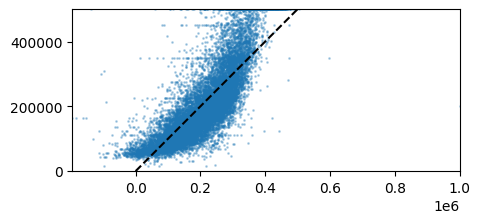

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(housing_predictions, housing_labels, s=1, alpha=0.3)
ax.axline((0, 0), slope=1, c='k', ls='--')
ax.set_aspect('equal')
ax.autoscale(enable=True, axis='both', tight=True)

In [109]:
from sklearn.metrics import mean_squared_error

lin_reg_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_reg_rmse

68831.98440583335

In [110]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                  ClusterTransformer(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB4A2D5F90>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

完了...overfitting了...

In [111]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
tree_rmse

0.0

#### Better Evaluation Using Cross-Validation

`sklearn.model_selection` 中的 `cross_val_score` 函數用於執行交叉驗證，它會將資料切分為訓練集和驗證集，並返回每個驗證集上的評估分數。

在使用 `cross_val_score` 時，需要特別注意使用的評估函數（scoring function）應該是一個<u><b>「效用函數」（utility function）</b></u>，而不是<u><b>「成本函數」（cost function）</b></u>。也就是 `cross_val_score` 預期較高的分數表示較好的模型表現。

In [112]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     66354.333214
std       1961.249494
min      62111.629941
25%      65389.895312
50%      66883.212924
75%      67630.601638
max      68595.829637
dtype: float64

`pd.Series` 和 `pd.DataFrame` 是 Pandas 中的兩個主要數據結構。

主要區別如下：
- **維度不同**：`pd.Series` 是**一維數據結構**，類似於帶有索引的一維數組或列向量。而 `pd.DataFrame` 是**二維數據結構**，類似於一個表格，包含多個列和行。

- **結構不同**：`pd.Series` 只包含**單一的數據列**，並且每個元素都具有相應的索引。 `pd.DataFrame` 則可以包含多個數據列，每個列都有自己的名稱，並且同時具有**行索引和列索引**。

- **數據類型不同**：`pd.Series` 中的**數據類型是一致**的，可以是數值、字符串、布爾值等。而 `pd.DataFrame` 中的**每一列可以有不同的數據類型**，可以混合數值、字符串、日期等。


In [113]:
# compare linear model's rmse
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(lin_rmses).describe()

count       10.000000
mean     70070.966837
std       3875.841085
min      65802.293415
25%      68704.064355
50%      68928.768974
75%      69930.710277
max      80332.933784
dtype: float64

我們可以使用`隨機森林（Random Forest）`來進行實驗，預期它的結果應該比線性模型和決策樹還要好。

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

即使使用這種模型，仍然存在`過度擬合（overfitting）`的可能性。為了檢驗這個問題，我們可以將整個訓練集用於模型訓練並進行評估。

In [ ]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

17468.316444785585

### Fine-Tune Your Model
#### Grid Search

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])


In [118]:
full_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000015...
                                                 ('geo',
                                                  ClusterTransformer(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000015371C1CA90>)])),
                ('random_forest', RandomForestRegressor(random_state=42))])

`GridSearchCV`使用雙底線 `__` 來分隔不同層級的參數。參數名稱中的每個雙底線表示一個層級的嵌套。這種命名規則用於指定參數在`Pipeline`或`ColumnTransformer`等結構中的位置。

`GridSearchCV`會將`param_grid`中的參數組合作為關鍵字傳遞給`full_pipeline`。例如，如果`param_grid`中包含`preprocessing__geo__n_clusters`，`full_pipeline`將首先找到`preprocessing`這個`ColumnTransformer`，然後在其中尋找`geo`這個轉換器，最後找到`n_clusters`這個參數。

<span style="color:lightgreen">嘿沒錯，現在你知道為什麼pipeline不能用雙底線 `__` 命名了: )</span>。

注意：看這邊`GridSearchCV`的`list`內有兩個`dict`，他們是分開的排列組合，因此總共是$3\times3+2\times3=15$種組合。

In [121]:
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000014C92E649A0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [122]:
pd.DataFrame(grid_search.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_preprocessing__geo__n_clusters',
       'param_random_forest__max_features', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

+ `mean_fit_time`: 平均訓練時間（浮點數）
+ `std_fit_time`: 訓練時間的標準差（浮點數）
+ `mean_score_time`: 平均評估時間（浮點數）
+ `std_score_time`: 評估時間的標準差（浮點數）
+ 各種參數設定
	- `param_preprocessing__geo__n_clusters`: preprocessing__geo__n_clusters 的參數值（物件）
	- `param_random_forest__max_features`: random_forest__max_features 的參數值（物件）
	- `params`: 參數組合（字典）
+ 各次分割的測試分數
	- `split0_test_score`: 第一次分割的測試分數（浮點數）
	- `split1_test_score`: 第二次分割的測試分數（浮點數）
	- `split2_test_score`: 第三次分割的測試分數（浮點數）
`mean_test_score`: 平均測試分數（浮點數）
`std_test_score`: 測試分數的標準差（浮點數）
`rank_test_score`: 測試分數的排名（整數）

In [133]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43412,43898,44821,44043
13,15,8,43953,44136,44881,44323
14,15,10,44228,44535,45300,44688
7,10,6,44872,44917,46281,45357
9,10,6,44872,44917,46281,45357


In [134]:
cv_res

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43412,43898,44821,44043
13,15,8,43953,44136,44881,44323
14,15,10,44228,44535,45300,44688
7,10,6,44872,44917,46281,45357
9,10,6,44872,44917,46281,45357
6,10,4,45263,44835,46527,45542
4,8,6,45422,45252,46656,45776
8,10,8,45411,45361,46687,45820
10,10,8,45411,45361,46687,45820
3,8,4,45628,45375,46658,45887


CV 完成之後，可以使用 `best_params_` 屬性獲取最佳參數組合，並使用 `best_estimator_` 屬性獲取套用最佳參數組合的估計器。

注意：這裡的「最佳」是根據 `utility function` 來定義的，也就是說它優先選擇分數更高的模型。

In [122]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [131]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x0000014...
                                                  ClusterTransformer(n_clusters=15,
                                                                     random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000014C957A6B60>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

這裡有幾篇很不錯的文章討論hyper params tuning method。
- https://axk51013.medium.com/ml%E8%AA%BF%E5%8F%83%E6%95%B8%E7%A5%9E%E7%89%A9-successive-halving-sklearn-0-24%E9%96%8B%E5%A7%8B%E6%94%AF%E6%8F%B4-680f05c56519
- https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-python-c581a129d4e4

[Random Search (RS)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) 相較於 [Grid Search (GS)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 的優勢：

1. 超參數設定的彈性：RS能夠使用超參數的生成分布，在參數空間內自由探索，不像GS需提供確切參陣列合，增加了彈性和搜尋範圍。

2. 節省計算時間：RS能夠避免因添加過多無用的超參數而造成計算時間的浪費，較GS更有效率。

3. 靈活適應搜尋次數：不論需要探索多少次超參數候選人，RS都能配合，而GS則需要手動設定符合搜尋次數的超參陣列合，RS在這方面更具靈活性。


In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB4A22C160>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002AB4A81BE50>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [139]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# extra code – these few lines of code just make the DataFrame look nicer
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,40971,42300,42880,42050
8,32,7,41707,42379,43285,42457
0,41,16,42325,42814,43270,42803
5,42,4,41637,43173,43912,42907
2,23,8,42442,42933,43856,43077


In [142]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

在 Scipy 中的隨機分佈提供了各種方法：
- `scipy.stats.randint(a, b+1)`：從 `a` 到 `b` 的離散均勻分布。
- `scipy.stats.uniform(a, b)`：從 `a` 到 `b` 的連續均勻分布。
- `scipy.stats.geom(1 / scale)`：`p=1/scale` 的幾何分布（離散型），適用於按特定比例取樣的情況。期望值為 scale。
    - 例如，設定 scale=1000，大多數樣本會在這個範圍內，但約有10% 的樣本值會小於100，約有10% 的樣本值會大於2300。
- `scipy.stats.expon(scale)`：`\beta=scale (\lambda=1/scale)`的指數分布（連續型），期望值為 scale。
- `scipy.stats.loguniform(a, b)`：對數均勻分布，當對超參數的 scale 沒有概念時（例如：超參數可能是0.1、1、10、...、10^5），可使用此方法（連續型）。是 `scipy.stats.reciprocal` 的別名。
    - 如果 $X \sim \text{log-uniformly}(a,b)$，則$\log(X) \sim \text{Uniformly}(\log(a), \log(b))$，詳見 [wiki](https://en.wikipedia.org/wiki/Reciprocal_distribution)

註: 所有 Scipy 中的隨機分佈都可以利用 `rvs` 方法產生隨機變量（random variates）。

In [ ]:
from scipy.stats import randint
randint(low=3, high=50).rvs(10)

array([49,  7, 22, 22,  7, 12, 18, 27, 46, 27], dtype=int64)

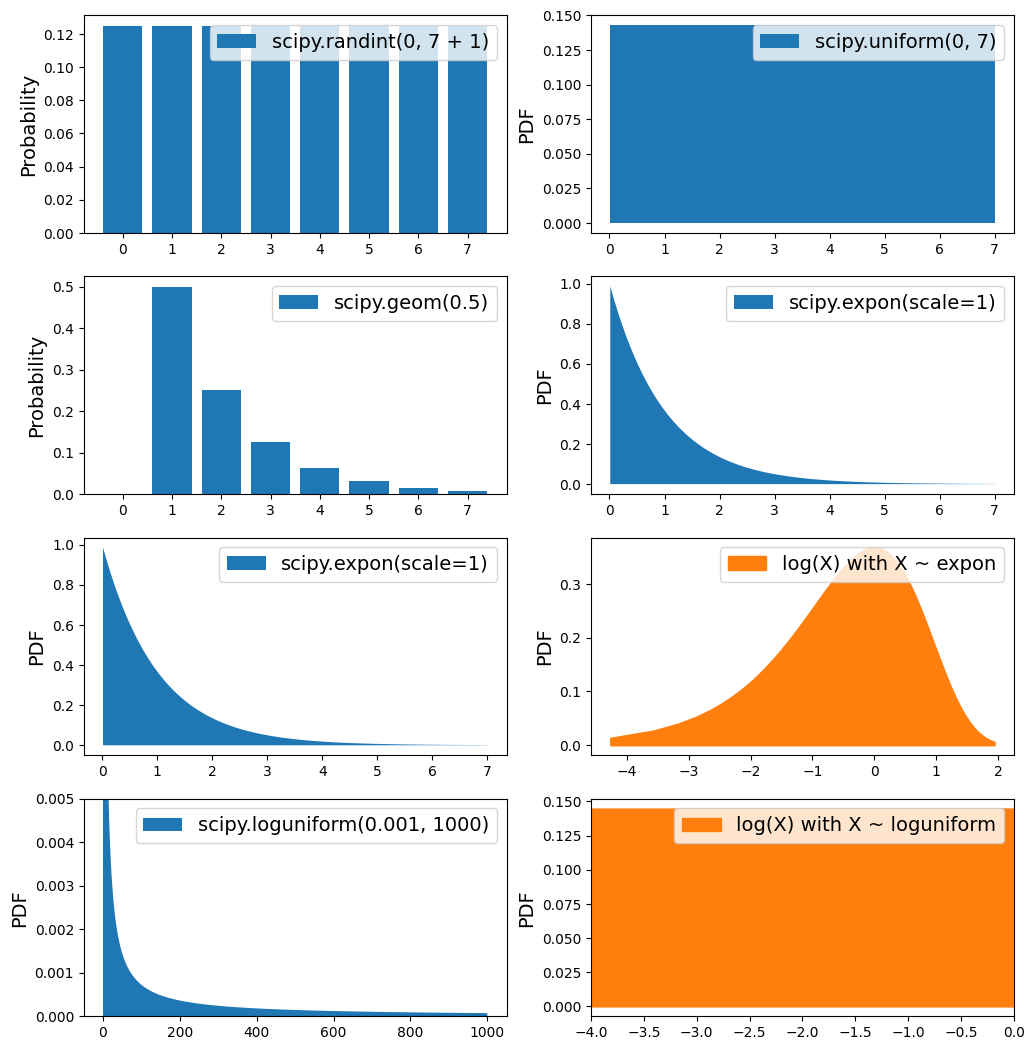

In [121]:
# just a simple code to demo difference between distributions
from scipy.stats import randint, uniform, geom, expon, loguniform

x_discrete = np.arange(0, 7+1)
x_continuous = np.linspace(0, 7, 500+1)[1:]
x_log = np.log(x_continuous)
x_exp = np.linspace(0.001, 1000, 500)

randint_distrib = randint(0, 7 + 1).pmf(x_discrete)
uniform_distrib = uniform(0, 7).pdf(x_continuous)
geom_distrib = geom(0.5).pmf(x_discrete)
expon_distrib = expon(scale=1).pdf(x_continuous)

log_expon_distrib = np.exp(x_log - np.exp(x_log))
loguniform_distrib = loguniform(0.001, 1000).pdf(x_exp)
log_loguniform_distrib = uniform(np.log(0.001), np.log(1000)).pdf(x_log)

fig, ax = plt.subplots(4, 2, figsize=(12, 13))

ax[0][0].bar(x_discrete, randint_distrib, label="scipy.randint(0, 7 + 1)")
ax[0][0].set_ylabel('Probability')

ax[0][1].fill_between(x_continuous, uniform_distrib, label="scipy.uniform(0, 7)")
ax[0][1].set_ylabel('PDF')

ax[1][0].bar(x_discrete, geom_distrib, label="scipy.geom(0.5)")
ax[1][0].set_ylabel('Probability')

ax[1][1].fill_between(x_continuous, expon_distrib, label="scipy.expon(scale=1)")
ax[1][1].set_ylabel('PDF')

ax[2][0].fill_between(x_continuous, expon_distrib, label="scipy.expon(scale=1)")
ax[2][0].set_ylabel('PDF')

ax[2][1].fill_between(x_log, log_expon_distrib, label="log(X) with X ~ expon", color='tab:orange')
ax[2][1].set_ylabel('PDF')

ax[3][0].fill_between(x_exp, loguniform_distrib, label="scipy.loguniform(0.001, 1000)")
ax[3][0].set_ylabel('PDF')
ax[3][0].set_ylim(0, 0.005)

ax[3][1].fill_between(x_log, log_loguniform_distrib, label="log(X) with X ~ loguniform", color='tab:orange')
ax[3][1].set_ylabel('PDF')
ax[3][1].set_xlim(-4, 0)

for ax in ax.flatten():
    ax.legend()
plt.show()

Scikit-Learn提供了`HalvingRandomSearchCV`，這是一種更有效率的分配計算資源的超參數調整器。與`RandomSearchCV`相似，但需使用`enable_halving_search_cv`來啟用此功能。

在`HalvingRandomSearchCV`中，不再使用`n_iter`的概念（其代表從參數空間組合中選擇幾個組合進行測試），而是採用`factor`參數。這個參數決定每個後續迭代中被選中的候選比例。例如，設定`factor=3`表示每次只會保留三分之一的候選參數到下一輪。

然而，需要注意`HalvingRandomSearchCV`會妥善分配資料數量，有時可能導致意料之外的錯誤。例如，在`preprocessing`步驟中使用了`ClusterTransformer`（其中使用kmeans將經緯度進行分群）。若分群數需超過資料量，則`fit`過程會產生錯誤，例如：

```text
FitFailedWarning: 
27 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.
```

這種情況下，可以使用`HalvingRandomSearchCV`提供的`error_score='raise'`參數，詳細檢查錯誤情況。

In [119]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [152]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

hrnd_search = HalvingRandomSearchCV(
    estimator=full_pipeline, param_distributions=param_distribs, factor=3, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42, max_resources=2000, min_resources=100, error_score='raise')

hrnd_search.fit(housing, housing_labels)

HalvingRandomSearchCV(cv=3, error_score='raise',
                      estimator=Pipeline(steps=[('preprocessing',
                                                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                              SimpleImputer(strategy='median')),
                                                                                             ('standardscaler',
                                                                                              StandardScaler())]),
                                                                   transformers=[('bedrooms',
                                                                                  Pipeline(steps=[('simpleimputer',
                                                                                                   SimpleImputer(strategy='median')),
                                                                                                  ('functiontransformer',
                                                                                                   FunctionTra...
                                                 RandomForestRegressor(random_state=42))]),
                      max_resources=2000, min_resources=100,
                      param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001539B9AF2E0>,
                                           'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001539BA13A00>},
                      random_state=42, scoring='neg_root_mean_squared_error')

#### Ensemble Methods

#### Analyzing the Best Models and Their Errors

In [119]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.01, 0.01, 0.03,
       0.01, 0.  , 0.01, 0.01, 0.01, 0.01, 0.02, 0.  , 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.  ,
       0.02, 0.  , 0.01, 0.02, 0.01, 0.04, 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [120]:
feature_importances_df = pd.DataFrame({
    'name': final_model["preprocessing"].get_feature_names_out(), 
    'value': feature_importances})

In [122]:
feature_importances_df.head()

,name,value
0,bedrooms__ratio,0.070374
1,rooms_per_house__ratio,0.056265
2,people_per_house__ratio,0.047820
3,log__total_bedrooms,0.006762
4,log__total_rooms,0.007623


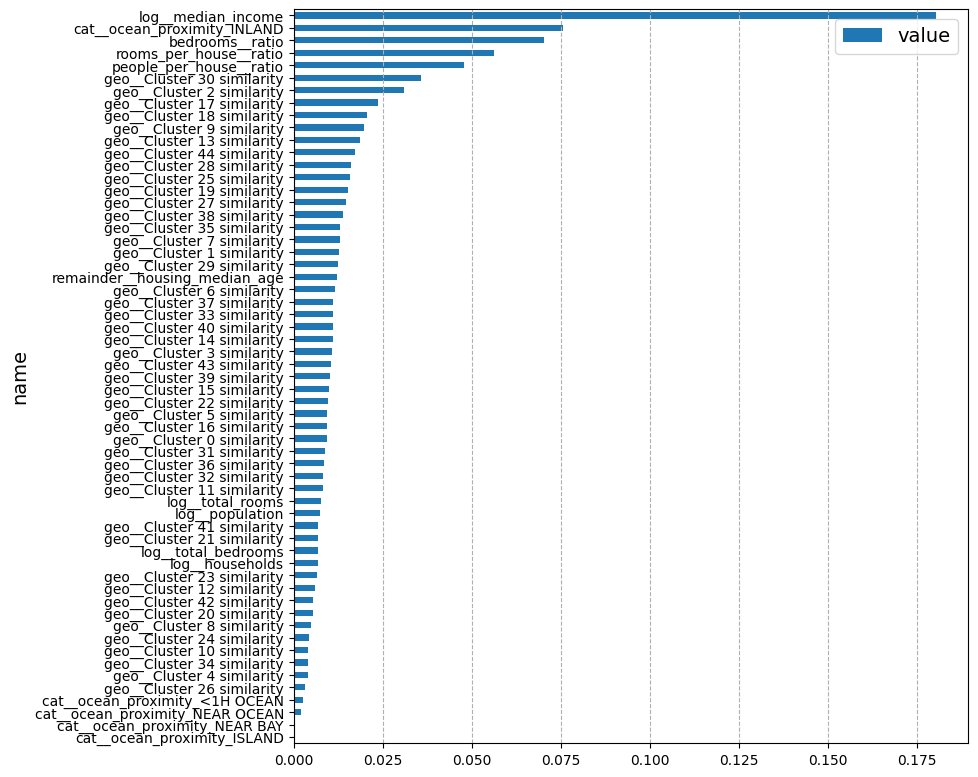

In [123]:
feature_importances_df.sort_values(by='value').plot.barh(x='name', y='value', figsize = (10,8))
plt.grid(axis='x', ls='--')
plt.tight_layout()

#### Evaluate Your System on the Test Set

計算誤差的 MSE

In [125]:
from sklearn.metrics import mean_squared_error

In [121]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print('final_rmse:', final_rmse)

final_rmse: 41377.77684666325


誤差的平方遵循 t 分佈，其中自由度為 n-1。

在這段程式碼中，使用了 `stats.t.interval` 來計算置信區間。具體來說，`confidence` 設置了信心水準（此處為 0.95），而 `squared_errors` 則包含了最終預測值與測試集 `y_test` 之間的平方誤差。這些平方誤差被用來計算均值 `squared_errors.mean()` 和標準誤差 `stats.sem(squared_errors)`。此處的標準誤差計算方式為 `s / sqrt(n)`，其中 `s` 為樣本標準差，`n` 為樣本數。

可以通過 [Scipy doc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html) 查看更多關於 `stats.sem` 的資訊。其計算公式為 $\frac{s}{\sqrt{n}}$，等同於 `np.std(data, ddof=1) / np.sqrt(np.size(data))`。

這是使用 `scipy.t.interval` 的版本 

In [122]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39253.18090229, 43398.48640906])

也可以自己手刻

In [123]:
squared_errors_mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence)/2, df=len(squared_errors) - 1)
tmargin = tscore * np.std(squared_errors, ddof=1) / np.sqrt(len(squared_errors))
np.sqrt(squared_errors_mean - tmargin), np.sqrt(squared_errors_mean + tmargin)

(39253.18090228564, 43398.48640905533)

當然，其實要用常態分配也是可以的，但因為測試資料集足夠大，所以差異並不大。

In [124]:
zscore = stats.norm.ppf((1 + confidence)/2)
zmargin = zscore * np.std(squared_errors, ddof=1) / np.sqrt(len(squared_errors))
np.sqrt(squared_errors_mean - zmargin), np.sqrt(squared_errors_mean + zmargin)

(39253.820857206694, 43397.90757231099)

### Launch, Monitor, and Maintain Your System

當要儲存或載入大型 NumPy 陣列時，`joblib` 的速度更快；而在處理大量 Python 物件時，`pickle` 的速度較快。這是由 Medium 上一篇有關此議題的文章指出的差異。總的來說，若您的模型包含較大的 NumPy 陣列（這在大多數模型中是常見的），使用 `joblib` 可以獲得更快的效能。更多細節可以參考 [Medium 文章](https://medium.com/nlplanet/is-it-better-to-save-models-using-joblib-or-pickle-776722b5a095)。

在實際測試中，`joblib` 使用了 125778KB 的空間，而 `pickle` 則使用了 125771KB，兩者之間的差異並不明顯。

In [126]:
import joblib
joblib.dump(final_model, 'models/my_california_housing_model.pkl')

['models/my_california_housing_model.pkl']

In [129]:
import pickle
with open('models/my_california_housing_model2.pkl', 'wb') as f:
    pickle.dump(final_model, f)

部屬模型的時候，可以使用REST API來變成應用服務，Google's Vertex AI也提供上傳pickle file到Google Cloud Storage (GCS)後，啟用的網頁服務。後面在第19章的時候會提及使用vertex ai 部屬tensorflow模型，本質上與部屬sklearn模型是一樣的。

部屬完成後，應該還要持續的監控系統，因為系統可能會退化。監控模型的指標，需要基於任務類型的不同而改變。失效時，有可能是資料流有問題，也可能是需要新資料來重新訓練模型。

監控系統通常比建置模型還要花費時間，但總得來說有三個方向可以做

- Collect fresh data regularly and label it (e.g., using human raters).

- Write a script to train the model and fine-tune the hyperparameters automatically. This script could run automatically, for example every day or every week, depending on your needs. 

- Write another script that will evaluate both the new model and the previous model on the updated test set, and deploy the model to production if the performance has not decreased (if it did, make sure you investigate why). The script should probably test the performance of your model on various subsets of the test set,

另外，也應該確保模型的輸入資料品質，包含感測器失效、資料延遲、資料缺失等等，也可以針對品質不佳增加alarm的規則。

ALso, 記得備份模型，當模型失效的時候可以退回之前的模型。

總之，第19章會講到MLops的東西，雖然第一個 ML 專案需要花費大量精力和時間來建置和部署到生產環境，但一旦所有基礎設施到位，從想法到生產的速度就會快得多。

當部署模型時，使用REST API轉換為應用服務是一種方法。Google的Vertex AI提供了將pickle文件上傳到Google Cloud Storage (GCS)，然後啟動網頁服務的功能。在第19章中將介紹使用Vertex AI部署TensorFlow模型，其實與部署Scikit-Learn模型的本質相同。

部署後，持續監控系統也很重要，因為系統可能會出現退化。監控模型的指標因任務類型不同而異。當系統失效時，可能是資料流問題或需要新資料重新訓練模型。

監控系統通常比建置模型更耗時，但有三個方向可考慮：
- 定期收集新鮮資料並加以標記（例如使用人工標註者）。
- 撰寫腳本自動訓練模型和微調超參數。例如，根據需求，腳本可以每天或每週自動運行。
- 撰寫另一個腳本，在更新的測試集上評估新舊模型的表現。如果模型表現沒有下降（若有下降，務必調查原因），則將模型部署到生產環境。腳本可能會在測試集的不同子集上測試模型的表現。

同時，也要確保模型的輸入資料品質，包括感測器故障、資料延遲和缺失等。可根據品質不佳的情況設置警報規則。

此外，在模型失效時，要記得備份模型，以便能夠回退至之前的版本。

總之，第19章將涵蓋MLOps的相關內容。雖然第一個ML專案需要大量時間和精力進行基礎建設和部署，但一旦基礎架構就緒，從概念到產品的速度將會更快。